# SSD行人检测

本次实验是基于MindSpore1.7框架搭建的SSD300目标检测网络，通过将提供的行人检测数据集转换为MindRecord格式，到SSD网络的搭建，以及最后的训练与验证过程，可以掌握MindSpore框架，以便在后续的学习过程中应用该框架搭建自己的网络模型。

## 1、SSD网络介绍

### 1.1 SSD网络框架整体介绍

[原论文地址](https://arxiv.org/abs/1512.02325)

SSD(Single Shot MultiBox Detector)是作者Wei Liu 于2016年在ECCV上发表的论文。当输入是300×300的网络在VOC2007测试集上达到74.3%的mAP，检测速度达到59FPS，对于输入是512×512的网络达到了76.9%的mAP，超越了当时的Faster-RCNN(73.2%)。由于Faster-RCNN只使用了最后的conv5_3的特征图作为特征预测层，导致其对小目标物体的检测效果不佳，而SSD目标检测网络则使用了多个特征图作为特征预测层。网络具体结构如下图所示：

<div align="center">
  <img src="./images/SSD整体框架结构图.png" width="85%" height="65%">
</div>

<div align="center">
  <img src="./images/VGG_16.png" width="80%" height="60%">
</div>

网络沿用了[VGG-16](https://arxiv.org/pdf/1409.1556.pdf)的Conv5_3层之前的所有结构，将VGG-16的第5个池化层(pool_5)从2×2，步长2改为3×3，步长1，因此通过修改后的pool_5特征图的大小不变，依旧是Conv5_3的输出大小19×19×512，将VGG-16的两个全连接层(FC6 & FC7)改为两个卷积层(Conv6 & Conv7)，随后增加了4个卷积层。

随着网络层数的加深，提取到的特征信息抽象程度也随之加大，高层语义信息中小目标物体的特征信息会减少，因此，网络提取最后选取Conv4_3、Conv7、Conv8_2、Conv9_2、Conv10_2、Conv11_2的特征图作为预测特征层，从而实现针对不同大小物体的目标检测。

<div align="center">
  <img src="./images/不同大小的特征图检测不同大小的物体.png" width="50%" height="50%">
</div>

### 1.2 预测器的实现

3×3卷积核实现类别分数预测以及坐标偏移量回归。对于每个预测特征层上的每个位置，会有k个默认框，对每个默认框进行预测，所以输出大小为：

$$m×n×k×(c+4)$$

其中，$m,n$为当前特征预测层的宽高，$k$为预测特征层每个位置上产生的默认框的个数，$c$为加上背景后的类别数，$4$为边界框坐标$(x,y,w,h)$回归参数的个数。

> NOTCIE: **默认生成框**、**正负样本匹配**以及**损失函数**将在后续部分结合代码介绍

### 1.3 选择实验环境

运行下面代码，在下拉菜单中选择实验环境，目前支持CPU和Ascend NPU切换。

In [1]:
import os
import mindspore
from mindspore import Model, context
import ipywidgets as wgs # 控件

dropdown = wgs.Dropdown(description="Select Device", options=['Click to choose', 'CPU', 'Ascend NPU'])
output = wgs.Output()
def changeDevice(change):
    output.clear_output()
    token = change.new
    with output:
        if token == 'Click to choose':
            print("请选择运行环境")
        if token == 'CPU':
            print("请确认当前环境为CPU\n======================================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
                print("已检查！确认当前环境为CPU")
            except ValueError:
                print("错误！当前是系统硬件不是CPU，请重新选择合适的硬件设备")
        if token == 'Ascend NPU':
            print("请确认当前环境为Ascend NPU\n===============================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
                print("当前环境为Ascend NPU")
            except ValueError:
                print("错误！当前是系统硬件不是Ascend NPU，请重新选择合适的硬件设备")

dropdown.observe(changeDevice, names='value')
display(dropdown, output)

Dropdown(description='Select Device', options=('Click to choose', 'CPU', 'Ascend NPU'), value='Click to choose…

Output()

运行下面代码继续完成硬件平台配

In [2]:
mindspore.set_seed(1)
if dropdown.value == 'CPU':
    print("选择的环境是：" + dropdown.value)
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        data_path = './dataset/pedestrian_detection'
        epochs = 10
        output_path = './checkpoints'
        checkpoint_path = './checkpoints'
        checkpoint_file_path = 'pretrained.ckpt'
        epoch_size = 1
        pre_trained = os.path.join(checkpoint_path, checkpoint_file_path)
        mode_sink = ''
        voc_json = os.path.join(data_path, 'classes.json')
        load_ckpt = True
        batch_size = 2
        print("CPU环境设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
elif dropdown.value == 'Ascend NPU':
    print("选择的环境是：" + dropdown.value)
    device_id = 0
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
        print("Ascend NPU环境设置成功！")
        epoch_size = 10
        data_path = './dataset/pedestrian_detection'
        output_path = './checkpoints'
        checkpoint_path = './checkpoints'
        checkpoint_file_path = 'pretrained.ckpt'
        pre_trained = os.path.join(checkpoint_path, checkpoint_file_path)
        mode_sink = 'sink'
        voc_json = os.path.join(data_path, 'classes.json')
        load_ckpt = True
        batch_size = 8
    except ValueError:
        print("错误！当前是系统硬件不支持Asend NPU，请返回上一步重新选择合适的硬件设备")
elif dropdown.value == 'Click to chose':
    print("未手动选择运行环境")
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        data_path = './dataset/pedestrian_detection'
        epochs = 10
        output_path = './checkpoints'
        checkpoint_path = './checkpoints'
        checkpoint_file_path = 'pretrained.ckpt'
        epoch_size = 1
        pre_trained = os.path.join(checkpoint_path, checkpoint_file_path)
        mode_sink = ''
        voc_json = os.path.join(data_path, 'classes.json')
        load_ckpt = True
        print("默认运行为CPU环境，已设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
else:
    print("未手动选择运行环境")
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        data_path = './dataset/pedestrian_detection'
        epochs = 10
        output_path = './checkpoints'
        checkpoint_path = './checkpoints'
        checkpoint_file_path = 'pretrained.ckpt'
        epoch_size = 1
        pre_trained = os.path.join(checkpoint_path, checkpoint_file_path)
        mode_sink = ''
        voc_json = os.path.join(data_path, 'classes.json')
        load_ckpt = True
        print("默认运行为CPU环境，已设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")

选择的环境是：CPU
CPU环境设置成功！


## 2、数据处理部分

+ 本次实验选用的数据集为**行人检测数据集**，一共有**485**张图片及其标注信息

+ 其中将 **90%** 的数据用于**训练**任务，其余 **10%** 用于**验证**任务

### 2.1 数据集下载

+ 数据下载，并解压到   **'./dataset'**   路径中

In [3]:
import os
import requests
import time
import zipfile

# 自动下载并解压数据集到指定文件夹内
def download_and_unzip(url, path):
    if not os.path.exists(path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(path)
    file_path = os.path.join(path, 'case10.zip')
    start = time.time() #下载开始时间
    user, password = 'tyx_neu', 'Sportlab307'
    resp = requests.get(url, auth=(user, password), stream=True)      #把下载地址发送给requests模块
    size = 0    #初始化已下载大小
    chunk_size = 1024  # 每次下载的数据大小
    content_size = int(resp.headers['content-length'])  # 下载文件总大小
    try:
        if resp.status_code == 200:   #判断是否响应成功
            print('Start download,[File size]:{size:.2f} MB'.format(size=content_size/chunk_size/1024))   #开始下载，显示下载文件大小
            with open(file_path, 'wb') as file:   #显示进度条
                for data in resp.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    size += len(data)
                    print('\r'+'[下载进度]:%s%.2f%%' % ('>'*int(size*50/content_size), float(size/content_size*100)), end=' ')
        end = time.time()   #下载结束时间
        print('\n'+'Download completed!,times: %.2f秒' % (end - start))  #输出下载用时时间
    except ValueError:
        print('Error!')
    unzip_file_path = path
    if not os.path.exists(unzip_file_path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(unzip_file_path)
    zip_file = zipfile.ZipFile(file_path)
    zip_list = zip_file.namelist()  # 压缩文件清单，可以直接看到压缩包内的各个文件的明细
    for f in zip_list:  # 遍历这些文件，逐个解压出来，
        zip_file.extract(f, unzip_file_path)
    zip_file.close()
    print('Successfully unzip download dataset from website!')

#下载地址
url = 'https://openi.pcl.ac.cn/attachments/486f8fa8-b022-4399-8049-d89c28e695ba?type=1'
download_and_unzip(url, os.path.join(os.getcwd(), 'dataset'))

Start download,[File size]:154.98 MB
[下载进度]:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00% 
Download completed!,times: 178.77秒
Successfully unzip download dataset from website!


### 2.2 类别定义

In [3]:
#类别标签名（包括背景）
classes = ["background", "person"]

### 2.3 数据集格式转换

+ 将voc数据集中的**xml格式的图像标注信息转换成为字典的形式**，为后续数据集读取做准备

In [4]:
import xml.etree.ElementTree as et
#使用Element表示xml中的节点、文本、注释
import os

voc_json = os.path.join(data_path, 'classes.json')

def get_imageId_from_fileName(filename, id_iter):
    """Get imageID from fileName if fileName is int, else return id_iter."""
    filename = os.path.splitext(filename)[0]
    if filename.isdigit():
        return int(filename)
    return id_iter

def create_voc_label(is_training, is_testing):
    """Get image path and annotation from VOC."""
    voc_root = data_path
    cls_map = {name: i for i, name in enumerate(classes)}
    if is_training:
        sub_dir = 'train'
    elif is_testing:
        sub_dir = 'test'
    else:
        sub_dir = 'eval'
    voc_dir = os.path.join(voc_root, sub_dir)
    if not os.path.isdir(voc_dir):
        raise ValueError(f'Cannot find {sub_dir} dataset path.')

    image_dir = anno_dir = voc_dir
    if os.path.isdir(os.path.join(voc_dir, 'Images')):
        image_dir = os.path.join(voc_dir, 'Images')
    if os.path.isdir(os.path.join(voc_dir, 'Annotations')):
        anno_dir = os.path.join(voc_dir, 'Annotations')

    if not (is_training or is_testing):
        json_file = os.path.join(voc_root, voc_json)
        file_dir = os.path.split(json_file)[0]
        if not os.path.isdir(file_dir):
            os.makedirs(file_dir)
        json_dict = {"images": [], "type": "instances", "annotations": [],
                     "categories": []}
        bnd_id = 1

    image_files_dict = {}
    image_anno_dict = {}
    images = []
    id_iter = 0
    for anno_file in os.listdir(anno_dir):
        print(anno_file)
        if not anno_file.endswith('xml'):
            continue
        tree = et.parse(os.path.join(anno_dir, anno_file))
        root_node = tree.getroot()
        file_name = root_node.find('filename').text
        img_id = get_imageId_from_fileName(file_name, id_iter)
        id_iter += 1
        image_path = os.path.join(image_dir, file_name)
        print(image_path)
        if not os.path.isfile(image_path):
            print(f'Cannot find image {file_name} according to annotations.')
            continue

        labels = []
        for obj in root_node.iter('object'):
            cls_name = obj.find('name').text
            if cls_name not in cls_map:
                print(f'Label "{cls_name}" not in "{classes}"')
                continue
            bnd_box = obj.find('bndbox')
            x_min = int(float(bnd_box.find('xmin').text)) - 1
            y_min = int(float(bnd_box.find('ymin').text)) - 1
            x_max = int(float(bnd_box.find('xmax').text)) - 1
            y_max = int(float(bnd_box.find('ymax').text)) - 1
            labels.append([y_min, x_min, y_max, x_max, cls_map[cls_name]])

            if not (is_training or is_testing):
                o_width = abs(x_max - x_min)
                o_height = abs(y_max - y_min)
                ann = {'area': o_width * o_height, 'iscrowd': 0, 'image_id': \
                    img_id, 'bbox': [x_min, y_min, o_width, o_height], \
                       'category_id': cls_map[cls_name], 'id': bnd_id, \
                       'ignore': 0, \
                       'segmentation': []}
                json_dict['annotations'].append(ann)
                bnd_id = bnd_id + 1

        if labels:
            images.append(img_id)
            image_files_dict[img_id] = image_path
            image_anno_dict[img_id] = np.array(labels)

        if not (is_training or is_testing):
            size = root_node.find("size")
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            image = {'file_name': file_name, 'height': height, 'width': width,
                     'id': img_id}
            json_dict['images'].append(image)

    if not (is_training or is_testing):
        for cls_name, cid in cls_map.items():
            cat = {'supercategory': 'none', 'id': cid, 'name': cls_name}
            json_dict['categories'].append(cat)
        json_fp = open(json_file, 'w')
        json_str = json.dumps(json_dict)
        json_fp.write(json_str)
        json_fp.close()


    return images, image_files_dict, image_anno_dict

+ 用FileWriter API将**数据转换成MindRecord格式**。需要注意的是**生成MindRecord文件后，如果修改文件名，可能会导致读取文件失败**。

In [5]:
import numpy as np
from mindspore.mindrecord import FileWriter
#将用户自定义的数据转为MindRecord格式的数据集

def voc_data_to_mindrecord(mindrecord_dir, is_testing, is_training, prefix="ssd.mindrecord", file_num=8):
    """Create MindRecord file by image_dir and anno_path."""
    mindrecord_path = os.path.join(mindrecord_dir, prefix)
    writer = FileWriter(mindrecord_path, file_num)
    images, image_path_dict, image_anno_dict = create_voc_label(is_training, is_testing)

    ssd_json = {
        "img_id": {"type": "int32", "shape": [1]},
        "image": {"type": "bytes"},
        "annotation": {"type": "int32", "shape": [-1, 5]},
    }
    writer.add_schema(ssd_json, "ssd_json")

    for img_id in images:
        image_path = image_path_dict[img_id]
        with open(image_path, 'rb') as f:
            img = f.read()
        annos = np.array(image_anno_dict[img_id], dtype=np.int32)
        img_id = np.array([img_id], dtype=np.int32)
        row = {"img_id": img_id, "image": img, "annotation": annos}
        writer.write_raw_data([row])
    writer.commit()

+ **创建MindRecord格式的数据集**，并生成MindRecord文件

In [6]:
def create_mindrecord(dataset="voc", prefix="ssd.mindrecord", is_training=True, is_testing=False):
    print("Start create dataset!")

    # It will generate mindrecord file in config.mindrecord_dir,
    # and the file name is ssd.mindrecord0, 1, ... file_num.

    mindrecord_dir = data_path
    print(mindrecord_dir)
    mindrecord_file = os.path.join(mindrecord_dir, prefix + "0")
    if not os.path.exists(mindrecord_file):
        if not os.path.isdir(mindrecord_dir):
            os.makedirs(mindrecord_dir)
        if dataset == "voc":
            voc_root = data_path
            if os.path.isdir(voc_root):
                print("Create Mindrecord.")
                voc_data_to_mindrecord(mindrecord_dir, is_training=is_training, prefix=prefix, is_testing=is_testing)
                print("Create Mindrecord Done, at {}".format(mindrecord_dir))
            else:
                print("voc_root not exits.")
    return mindrecord_file

### 2.4 加载数据集

+ 使用MindDataset API**加载MindRecord格式数据集**，读取和解析MindRecord数据文件构建数据集。生成的数据集的列名和列类型取决于MindRecord文件中的保存的列名与类型。

+ 进行**数据增强**

In [7]:
def intersect(box_a, box_b):
    """Compute the intersect of two sets of boxes."""
    max_yx = np.minimum(box_a[:, 2:4], box_b[2:4])
    min_yx = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_yx - min_yx), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]

+ 计算交并比

In [8]:
def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes."""
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2] - box_a[:, 0]) *
              (box_a[:, 3] - box_a[:, 1]))
    area_b = ((box_b[2] - box_b[0]) *
              (box_b[3] - box_b[1]))
    union = area_a + area_b - inter
    return inter / union

+ 随机裁剪

In [9]:
def _rand(a=0., b=1.):
    """Generate random."""
    return np.random.rand() * (b - a) + a

def random_sample_crop(image, boxes):
    """Random Crop the image and boxes"""
    height, width, _ = image.shape
    min_iou = np.random.choice([None, 0.1, 0.3, 0.5, 0.7, 0.9])

    if min_iou is None:
        return image, boxes

    # max trails (50)
    for _ in range(50):
        image_t = image

        w = _rand(0.3, 1.0) * width
        h = _rand(0.3, 1.0) * height

        # aspect ratio constraint b/t .5 & 2
        if h / w < 0.5 or h / w > 2:
            continue

        left = _rand() * (width - w)
        top = _rand() * (height - h)

        rect = np.array([int(top), int(left), int(top + h), int(left + w)])
        overlap = jaccard_numpy(boxes, rect)

        # dropout some boxes
        drop_mask = overlap > 0
        if not drop_mask.any():
            continue

        if overlap[drop_mask].min() < min_iou and overlap[drop_mask].max() > (min_iou + 0.2):
            continue

        image_t = image_t[rect[0]:rect[2], rect[1]:rect[3], :]

        centers = (boxes[:, :2] + boxes[:, 2:4]) / 2.0

        m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])
        m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

        # mask in that both m1 and m2 are true
        mask = m1 * m2 * drop_mask

        # have any valid boxes? try again if not
        if not mask.any():
            continue

        # take only matching gt boxes
        boxes_t = boxes[mask, :].copy()

        boxes_t[:, :2] = np.maximum(boxes_t[:, :2], rect[:2])
        boxes_t[:, :2] -= rect[:2]
        boxes_t[:, 2:4] = np.minimum(boxes_t[:, 2:4], rect[2:4])
        boxes_t[:, 2:4] -= rect[:2]

        return image_t, boxes_t
    return image, boxes


### 2.5 生成默认框

+ 在每个预测特征层的每个cell上都会生成默认框

+ 每个预测特征层上的默认框的尺寸以及数量设置如下表所示，表中$1:1$、$1:2$、$2:1$、$1:3$、$3:1$为默认框的比例，其中$1:1$的默认框会有两种尺寸

<div align="center">
  <img src="./images/DefaultBox设置.png" width="80%" height="60%">
</div>

+ 默认框尺寸的计算公式如下：

$$s_k=s_{min} +\frac{s_{max}-s_{min}}{m-1}{(k-1)}，k\in[1,m]$$

+ 本次实验中最小尺寸设置为$0.2$，最大尺寸设置为$0.95$，$m$为使用的特征图的个数，**SSD300中$m$为6**

In [10]:
import itertools as it
#迭代器模块导入
import math

#num_ssd_boxes = num_default×对应的特征图的大小
num_ssd_boxes = 1917

#特征图向原图映射的步长
steps = [16, 32, 64, 100, 150, 300]
#输入图像尺寸
img_shape = [300, 300]
#交并比匹配阈值
match_threshold = 0.5
#默认框的最小与最大尺寸设置
min_scale = 0.2
max_scale = 0.95
#每个预测层默认框的宽高比设置
aspect_ratios = [[], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3]]
#在对应的预测特征层的每个cell生成的default box的数量
num_default = [3, 6, 6, 6, 6, 6]
#每个预测特征层对应的输出特征图尺寸
feature_sizes = [19, 10, 5, 3, 2, 1]

class GeneratDefaultBoxes():
    """
    Generate Default boxes for SSD, follows the order of (W, H, archor_sizes).
    `self.default_boxes` has a shape of [archor_sizes, H, W, 4], the last dimension is [y, x, h, w].
    `self.default_boxes_tlbr` has a shape as `self.default_boxes`, the last dimension is [y1, x1, y2, x2].
    """
    def __init__(self):
        fk = img_shape[0] / np.array(steps)                              #fk为第k个特征图尺寸大小
        scale_rate = (max_scale - min_scale) / (len(num_default) - 1)
        scales = [min_scale + scale_rate * i for i in range(len(num_default))] + [1.0]
        self.default_boxes = []
        for idex, feature_size in enumerate(feature_sizes):
            sk1 = scales[idex]
            sk2 = scales[idex + 1]
            sk3 = math.sqrt(sk1 * sk2)
            if idex == 0 and not aspect_ratios[idex]:
                w, h = sk1 * math.sqrt(2), sk1 / math.sqrt(2)
                all_sizes = [(0.1, 0.1), (w, h), (h, w)]
            else:
                all_sizes = [(sk1, sk1)]
                for aspect_ratio in aspect_ratios[idex]:
                    w, h = sk1 * math.sqrt(aspect_ratio), sk1 / math.sqrt(aspect_ratio)
                    all_sizes.append((w, h))
                    all_sizes.append((h, w))
                all_sizes.append((sk3, sk3))

            assert len(all_sizes) == num_default[idex]

            #计算默认框相对于当前特征图的中心坐标，i为行，j为列
            for i, j in it.product(range(feature_size), repeat=2):
                for w, h in all_sizes:
                    cx, cy = (j + 0.5) / fk[idex], (i + 0.5) / fk[idex]
                    self.default_boxes.append([cy, cx, h, w])

        #将所有默认框(cy,cx,h,w)转换为(ymin,xmin,ymax,xmax)的形式，即左上和右下点坐标
        def to_tlbr(cy, cx, h, w):
            return cy - h / 2, cx - w / 2, cy + h / 2, cx + w / 2

        # For IoU calculation
        self.default_boxes_tlbr = np.array(tuple(to_tlbr(*i) for i in self.default_boxes), dtype='float32')
        self.default_boxes = np.array(self.default_boxes, dtype='float32')

default_boxes_tlbr = GeneratDefaultBoxes().default_boxes_tlbr
default_boxes = GeneratDefaultBoxes().default_boxes
y1, x1, y2, x2 = np.split(default_boxes_tlbr[:, :4], 4, axis=-1)
vol_anchors = (x2 - x1) * (y2 - y1)
matching_threshold = match_threshold


### 2.6 正负样本匹配

匹配准则：

+ (1)选择与Ground Truth交并比最大的默认框所对应的IOU值；

+ (2)将与当前标注信息中的每个Ground Truth交并比最大的默认框所对应的IOU值置为2，即选为正样本。若不进行这一步，将会有Ground Truth未匹配到默认框；

+ (3)将与Ground Truth交并比大于0.5的默认框也置为正样本。

In [11]:
prior_scaling = [0.1, 0.2]

#输入GT框的坐标信息bbox[0]-bbox[3]与标签信息bbox[4]
def ssd_bboxes_encode(boxes):
    """
    Labels anchors with ground truth inputs.

    Args:
        boxex: ground truth with shape [N, 5], for each row, it stores [y, x, h, w, cls].

    Returns:
        gt_loc: location ground truth with shape [num_anchors, 4].
        gt_label: class ground truth with shape [num_anchors, 1].
        num_matched_boxes: number of positives in an image.
    """

    #计算每个默认框与当前图片标注信息的每个GT的最大交并比
    def jaccard_with_anchors(bbox):
        """Compute jaccard score a box and the anchors."""
        # Intersection bbox and volume.
        ymin = np.maximum(y1, bbox[0])
        xmin = np.maximum(x1, bbox[1])
        ymax = np.minimum(y2, bbox[2])
        xmax = np.minimum(x2, bbox[3])
        w = np.maximum(xmax - xmin, 0.)
        h = np.maximum(ymax - ymin, 0.)

        # Volumes.
        inter_vol = h * w
        union_vol = vol_anchors + (bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) - inter_vol
        jaccard = inter_vol / union_vol
        return np.squeeze(jaccard)

    pre_scores = np.zeros((num_ssd_boxes), dtype=np.float32)    ##pre_scores用于存放默认框匹配的Ground Truth的交并比
    t_boxes = np.zeros((num_ssd_boxes, 4), dtype=np.float32)    #t_boxes用于存放与默认框匹配的Ground Truth的坐标信息
    t_label = np.zeros((num_ssd_boxes), dtype=np.int64)         #t_label用于存放默认框匹配的Ground Truth的标签信息
    for bbox in boxes:
        label = int(bbox[4])
        scores = jaccard_with_anchors(bbox)
        idx = np.argmax(scores)              #选取与当前GT交并比最大的默认框的索引值
        scores[idx] = 2.0                    #将与当前GT交并比最大的默认框所对应的IOU值置为2.0
        mask = (scores > matching_threshold) #将与GT交并比大于0.5的默认框均设置为正样本
        mask = mask & (scores > pre_scores)  #交并比是否比之前匹配的Ground Truth大
        pre_scores = np.maximum(pre_scores, scores * mask)  #所有正样本的交并比分数
        t_label = mask * label + (1 - mask) * t_label      #将正样本所对应的标签信息导出
        for i in range(4):
            t_boxes[:, i] = mask * bbox[i] + (1 - mask) * t_boxes[:, i]   #将正样本对应的Ground Truth坐标信息导出

    index = np.nonzero(t_label)  #存放与Ground Truth匹配的默认框的索引值，即哪个默认框与Ground Truth匹配

    # Transform to tlbr.  将(ymin,xmin,ymax,xmax)转换为(cy,cx,h,w)格式
    bboxes = np.zeros((num_ssd_boxes, 4), dtype=np.float32)           #bboxes用于存放已与默认框匹配的Ground Truth的坐标信息
    bboxes[:, [0, 1]] = (t_boxes[:, [0, 1]] + t_boxes[:, [2, 3]]) / 2
    bboxes[:, [2, 3]] = t_boxes[:, [2, 3]] - t_boxes[:, [0, 1]]

    # Encode features.
    bboxes_t = bboxes[index]
    default_boxes_t = default_boxes[index]
    #切片操作，计算所有的默认框与其匹配到的Ground Truth中心坐标偏差
    bboxes_t[:, :2] = (bboxes_t[:, :2] - default_boxes_t[:, :2]) / (default_boxes_t[:, 2:] * prior_scaling[0])
    tmp = np.maximum(bboxes_t[:, 2:4] / default_boxes_t[:, 2:4], 0.000001)
    #计算宽高缩放损失
    bboxes_t[:, 2:4] = np.log(tmp) / prior_scaling[1]
    bboxes[index] = bboxes_t
    #记录正样本个数
    num_match = np.array([len(np.nonzero(t_label)[0])], dtype=np.int32)
    return bboxes, t_label.astype(np.int32), num_match


### 2.7 生成数据集

+ 定义数据增强函数

In [12]:
import cv2

#进行数据增强
def preprocess_fn(img_id, image, box, is_training):
    """Preprocess function for dataset."""
    cv2.setNumThreads(2)

    def _infer_data(image, input_shape):
        img_h, img_w, _ = image.shape
        input_h, input_w = input_shape

        image = cv2.resize(image, (input_w, input_h))

        # When the channels of image is 1
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
            image = np.concatenate([image, image, image], axis=-1)

        return img_id, image, np.array((img_h, img_w), np.float32)

    def _data_aug(image, box, is_training, image_size=(300, 300)):
        """Data augmentation function."""
        ih, iw, _ = image.shape
        h, w = image_size

        if not is_training:
            return _infer_data(image, image_size)

        # Random crop
        box = box.astype(np.float32)
        image, box = random_sample_crop(image, box)
        ih, iw, _ = image.shape

        # Resize image
        image = cv2.resize(image, (w, h))

        # Flip image or not
        flip = _rand() < .5
        if flip:
            image = cv2.flip(image, 1, dst=None)      #水平翻转

        # When the channels of image is 1
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
            image = np.concatenate([image, image, image], axis=-1)

        box[:, [0, 2]] = box[:, [0, 2]] / ih
        box[:, [1, 3]] = box[:, [1, 3]] / iw

        if flip:
            box[:, [1, 3]] = 1 - box[:, [3, 1]]

        box, label, num_match = ssd_bboxes_encode(box)
        return image, box, label, num_match

    return _data_aug(image, box, is_training, image_size=[300, 300])


+ 定义加载数据函数

In [13]:
import multiprocessing
import mindspore.dataset as de

#加载数据
def create_ssd_dataset(mindrecord_file, batch_size=1, device_num=1, rank=0,
                       is_training=True, num_parallel_workers=4, use_multiprocessing=True, is_testing=False):
    """Create SSD dataset with MindDataset."""
    cores = multiprocessing.cpu_count()
    if cores < num_parallel_workers:
        print("The num_parallel_workers {} is set too large, now set it {}".format(num_parallel_workers, cores))
        num_parallel_workers = cores
    ##读取和解析MindRecord数据文件构建数据集
    if is_training:
        ds = de.MindDataset(mindrecord_file, columns_list=["img_id", "image", "annotation"], num_shards=device_num, shard_id=rank, num_parallel_workers=num_parallel_workers, shuffle=is_training)
    elif is_testing:
        ds = de.MindDataset(mindrecord_file, columns_list=["img_id", "image", "annotation"], num_shards=device_num, shard_id=rank, num_parallel_workers=num_parallel_workers, shuffle=is_testing)
    else:
        ds = de.MindDataset(mindrecord_file, columns_list=["img_id", "image", "annotation"], num_shards=device_num, shard_id=rank, num_parallel_workers=num_parallel_workers, shuffle=is_training)
    #将输入的压缩图像解码为RGB格式
    decode = de.vision.c_transforms.Decode()
    #给定一组数据增强列表，按顺序将数据增强作用在数据集对象上
    ds = ds.map(operations=decode, input_columns=["image"])
    #将输入图像的shape从 <H, W, C> 转换为 <C, H, W>
    change_swap_op = de.vision.c_transforms.HWC2CHW()
    #根据均值和标准差对输入图像进行归一化
    normalize_op = de.vision.c_transforms.Normalize(mean=[0.485 * 255, 0.456 * 255, 0.406 * 255], std=[0.229 * 255, 0.224 * 255, 0.225 * 255])
    #随机调整输入图像的亮度、对比度、饱和度和色调。
    color_adjust_op = de.vision.c_transforms.RandomColorAdjust(brightness=0.4, contrast=0.4, saturation=0.4)
    if is_training:
        compose_map_func = (lambda img_id, image, annotation: preprocess_fn(img_id, image, annotation, is_training))
    elif is_testing:
        compose_map_func = (lambda img_id, image, annotation: preprocess_fn(img_id, image, annotation, is_testing))
    else:
        compose_map_func = (lambda img_id, image, annotation: preprocess_fn(img_id, image, annotation, is_training))
    if is_training:
        output_columns = ["image", "box", "label", "num_match"]
        trans = [color_adjust_op, normalize_op, change_swap_op]
    elif is_testing:
        output_columns = ["image", "box", "label", "num_match"]
        trans = [color_adjust_op, normalize_op, change_swap_op]
    else:
        output_columns = ["img_id", "image", "image_shape"]
        trans = [normalize_op, change_swap_op]
    ds = ds.map(operations=compose_map_func, input_columns=["img_id", "image", "annotation"],
                output_columns=output_columns, column_order=output_columns,
                python_multiprocessing=use_multiprocessing,
                num_parallel_workers=num_parallel_workers)
    ds = ds.map(operations=trans, input_columns=["image"], python_multiprocessing=use_multiprocessing,
                num_parallel_workers=num_parallel_workers)
    #将数据集中连续 batch_size 条数据合并为一个批处理数据
    #当最后一个批处理数据包含的数据条目小于 batch_size 时，将该批处理丢弃，不传递给下一个操作
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds

+ 加载数据

In [14]:
import mindspore as ms

rank = 0
device_num = 1
loss_scale = 1.0
device_target = context.get_context("device_target")
mindrecord_file = create_mindrecord("voc", "ssd.mindrecord", is_training=True, is_testing=False)

# When create MindDataset, using the fitst mindrecord file, such as ssd.mindrecord0.
use_multiprocessing = (device_target != "CPU")

if device_target == "CPU":
    print('Because your device target is CPU, no multiprocessing')

dataset = create_ssd_dataset(mindrecord_file, batch_size=batch_size, device_num=device_num, rank=rank, use_multiprocessing=use_multiprocessing)

dataset_size = dataset.get_dataset_size()

print(f"Create dataset done! dataset size is {dataset_size}")

Start create dataset!
./dataset/pedestrian_detection
Because your device target is CPU, no multiprocessing
Create dataset done! dataset size is 218


## 3、SSD模型搭建

### 3.1 Backbone部分

采用[MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf) 作为backbone进行特征提取

+ 首先搭建带BatchNormalization以及ReLU6激活函数的卷积层

+ 注意：在ConvBNReLU层中**group参数**为1时为普通卷积操作，group参数为输入特征图通道数时为深度可分离卷积操作

In [15]:
import mindspore.nn as nn

def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-3, momentum=0.97,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

def _conv2d(in_channel, out_channel, kernel_size=3, stride=1, pad_mod='same'):
    return nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride,
                     padding=0, pad_mode=pad_mod, has_bias=True)

class ConvBNReLU(nn.Cell):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, shared_conv=None):
        super(ConvBNReLU, self).__init__()
        padding = 0
        in_channels = in_planes
        out_channels = out_planes
        if shared_conv is None:
            if groups == 1:
                conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='same', padding=padding)
            else:
                out_channels = in_planes
                conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='same',
                                 padding=padding, group=in_channels)
            layers = [conv, _bn(out_planes), nn.ReLU6()]
        else:
            layers = [shared_conv, _bn(out_planes), nn.ReLU6()]
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


定义[MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf) 的**反向残差结构**（反向残差结构如下图所示，(a)为残差结构，(b)为反向残差结构）

反向残差结构

+ 先通过一个$1×1$的普通卷积将$h×w×d$大小的特征图升维得到$h×w×td$大小的特征图，$t$对应代码中的扩展因子(expand_ratio)参数

+ 再通过$3×3$的深度方向的卷积(Depthwise Convolution)操作，所得到的特征图大小为 $\frac{h}{s}×\frac{w}{s}×td$

+ 最后通过$1×1$的点卷积(Pointwise Convolution)降维，此时使用的激活函数不是ReLU6激活函数，而是线性激活函数

反向残差结构中只有**当步距(stride=1)，且输入与输出特征维度相同时**，会有和残差结构中的**shortcut连接**

当**扩展因子为1**时，反向残差结构**第一层没有$1×1$的普通卷积**

<div align="center">
<img src="./images/backbone_反残差结构.png" width="60%" height="60%">
</div>

In [16]:
class InvertedResidual(nn.Cell):
    """
    Residual block definition.

    Args:
        inp (int): Input channel.
        oup (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.
        expand_ratio (int): expand ration of input channel

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, 1, 1)
    """
    def __init__(self, inp, oup, stride, expand_ratio, last_relu=False):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # Depthwise Convolution
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # Pointwise Convolution
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, has_bias=False),
            _bn(oup),
        ])
        self.conv = nn.SequentialCell(layers)
        self.cast = ops.Cast()
        self.last_relu = last_relu
        self.relu = nn.ReLU6()

    def construct(self, x):
        identity = x
        x = self.conv(x)
        if self.use_res_connect:
            x = identity + x
        if self.last_relu:
            x = self.relu(x)
        return x


搭建MobileNetV2网络结构

+ **_make_divisible函数将卷积核个数调整为round_nearest的整数倍**，这样操作对硬件友好

下图为MobileNetV2网络结构示意图，图中$t$为扩展因子，$c$为输出特征图深度，$n$为反向残差块重复次数，$s$为每个反向残差层中第一个反向残差块的步距

<div align="center">
<img src="./images/BackBone_MobileNetV2.png" width="40%" height="30%">
</div>

In [17]:
def _make_divisible(v, divisor, min_value=None):
    """nsures that all layers have a channel number that is divisible by 8."""
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class SSDWithMobileNetV2(nn.Cell):
    """
    MobileNetV2 architecture for SSD backbone.

    Args:
        width_mult (int): Channels multiplier for round to 8/16 and others. Default is 1.
        inverted_residual_setting (list): Inverted residual settings. Default is None
        round_nearest (list): Channel round to. Default is 8
    Returns:
        Tensor, the 13th feature after ConvBNReLU in MobileNetV2.
        Tensor, the last feature in MobileNetV2.

    Examples:
        >>> SSDWithMobileNetV2()
    """
    def __init__(self, width_mult=1.0, inverted_residual_setting=None, round_nearest=8):
        super(SSDWithMobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32          #第一层卷积层输出特征图深度
        last_channel = 1280         #最后一层输出特征图深度

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]
        if len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        #building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        layer_index = 0
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                if layer_index == 13:
                    hidden_dim = int(round(input_channel * t))
                    self.expand_layer_conv_13 = ConvBNReLU(input_channel, hidden_dim, kernel_size=1)     #该层将作为SSD网络的Feature Map1
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
                layer_index += 1
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))

        self.features_1 = nn.SequentialCell(features[:14])
        self.features_2 = nn.SequentialCell(features[14:])

    def construct(self, x):
        out = self.features_1(x)
        expand_layer_conv_13 = self.expand_layer_conv_13(out)
        out = self.features_2(out)
        return expand_layer_conv_13, out

    def get_out_channels(self):
        return self.last_channel


+ 定义`ssd_mobilenetv2`

In [18]:
def ssd_mobilenet_v2(**kwargs):
    return SSDWithMobileNetV2(**kwargs)

搭建后的Backbone部分结构框图如下所示：

<div align="center">
<img src="./images/SSD_MobileNetV2_Backbone.png" width="80%" height="60%">
</div>

### 3.2 搭建SSD300网络结构

+ 定义`FlattenConcat`类，将预测值展开级联成单个张量

In [19]:
import mindspore.ops as ops

class FlattenConcat(nn.Cell):
    """
    Concatenate predictions into a single tensor.

    Args:
        config (dict): The default config of SSD.

    Returns:
        Tensor, flatten predictions.
    """
    def __init__(self):
        super(FlattenConcat, self).__init__()
        self.num_ssd_boxes = 1917
        self.concat = ops.Concat(axis=1) #在指定轴上拼接输入Tensor
        self.transpose = ops.Transpose() #根据指定的排列对输入的Tensor进行数据重排
    def construct(self, inputs):
        output = ()
        batch_size = ops.shape(inputs[0])[0]
        for x in inputs:
            x = self.transpose(x, (0, 2, 3, 1))
            output += (ops.reshape(x, (batch_size, -1)),)
        res = self.concat(output)
        return ops.reshape(res, (batch_size, self.num_ssd_boxes, -1))


+ 定义最后一层卷积

In [20]:
def _last_conv2d(in_channel, out_channel, kernel_size=3, stride=1, pad_mod='same', pad=0):
    in_channels = in_channel
    out_channels = in_channel
    depthwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='same',
                               padding=pad, group=in_channels)
    conv = _conv2d(in_channel, out_channel, kernel_size=1)
    return nn.SequentialCell([depthwise_conv, _bn(in_channel), nn.ReLU6(), conv])

+ 定义多锚框类`MultiBox`

对Feature Map中的每个cell产生4×对应的default box个数的坐标回归参数，以及类别数×对应的default box个数的类别预测参数

In [21]:
class MultiBox(nn.Cell):
    """
    Multibox conv layers. Each multibox layer contains class conf scores and localization predictions.

    Returns:
        Tensor, localization predictions.
        Tensor, class conf scores.
    """
    def __init__(self):
        super(MultiBox, self).__init__()
        num_classes = 81
        out_channels = [576, 1280, 512, 256, 256, 128]
        num_default = [3, 6, 6, 6, 6, 6]

        loc_layers = []
        cls_layers = []
        for k, out_channel in enumerate(out_channels):
            loc_layers += [_last_conv2d(out_channel, 4 * num_default[k],
                                        kernel_size=3, stride=1, pad_mod='same', pad=0)]
            cls_layers += [_last_conv2d(out_channel, num_classes * num_default[k],
                                        kernel_size=3, stride=1, pad_mod='same', pad=0)]

        self.multi_loc_layers = nn.layer.CellList(loc_layers)
        self.multi_cls_layers = nn.layer.CellList(cls_layers)
        self.flatten_concat = FlattenConcat()

    def construct(self, inputs):
        loc_outputs = ()
        cls_outputs = ()
        for i in range(len(self.multi_loc_layers)):
            loc_outputs += (self.multi_loc_layers[i](inputs[i]),)
            cls_outputs += (self.multi_cls_layers[i](inputs[i]),)
        return self.flatten_concat(loc_outputs), self.flatten_concat(cls_outputs)

+ 将MobileNetV2的第12个输出大小为$14×14×96$的反向残差连接层截断，单独做一次`ConvBNReLU`卷积输出大小为$14×14×576$，将该输出特征图以及最后一层输出大小为$7×7×1280$的卷积层作为`Feature Map1、2`
+ 再通过4个ConvBNReLU层生成`Feature Map3`至`Feature Map6`
+ 将这6个预测特征层作坐标参数回归和类别预测

In [22]:
model_name = "ssd300"

class SSD300(nn.Cell):
    """
    SSD300 Network. Default backbone is resnet34.

    Args:
        backbone (Cell): Backbone Network.
        config (dict): The default config of SSD.

    Returns:
        Tensor, localization predictions.
        Tensor, class conf scores.

    Examples:backbone
         SSD300(backbone=resnet34(num_classes=None),
                config=config).
    """
    def __init__(self, backbone, is_training=True):
        super(SSD300, self).__init__()

        self.backbone = backbone
        in_channels = [256, 576, 1280, 512, 256, 256]
        out_channels = [576, 1280, 512, 256, 256, 128]
        ratios = [0.2, 0.2, 0.2, 0.25, 0.5, 0.25]
        strides = [1, 1, 2, 2, 2, 2]
        residual_list = []
        for i in range(2, len(in_channels)):
            residual = InvertedResidual(in_channels[i], out_channels[i], stride=strides[i],
                                        expand_ratio=ratios[i], last_relu=True)
            residual_list.append(residual)
        self.multi_residual = nn.layer.CellList(residual_list)
        self.multi_box = MultiBox()
        self.is_training = is_training
        if not is_training:
            self.activation = ops.Sigmoid()

    def construct(self, x):
        layer_out_13, output = self.backbone(x)
        multi_feature = (layer_out_13, output)
        feature = output
        for residual in self.multi_residual:
            feature = residual(feature)
            multi_feature += (feature,)
        pred_loc, pred_label = self.multi_box(multi_feature)
        if not self.is_training:
            pred_label = self.activation(pred_label)
        pred_loc = ops.cast(pred_loc, ms.float32)
        pred_label = ops.cast(pred_label, ms.float32)
        return pred_loc, pred_label


+ 初始化网络参数

In [23]:
#初始化神经元参数,生成一个服从截断正态（高斯）分布的随机数组用于初始化Tensor
from mindspore.common.initializer import initializer, TruncatedNormal

def init_net_param(network, initialize_mode='TruncatedNormal'):
    """Init the parameters in net."""
    params = network.trainable_params()
    for p in params:
        if 'beta' not in p.name and 'gamma' not in p.name and 'bias' not in p.name:
            if initialize_mode == 'TruncatedNormal':
                p.set_data(initializer(TruncatedNormal(0.02), p.data.shape, p.data.dtype))
            else:
                p.set_data(initialize_mode, p.data.shape, p.data.dtype)

+ 定义模型

In [24]:
def ssd_model_build():
    if model_name == "ssd300":
        backbone = ssd_mobilenet_v2()
        ssd = SSD300(backbone=backbone)
        init_net_param(ssd)
    else:
        raise ValueError(f'config.model: {model_name} is not supported')
    return ssd

+ 搭建模型

In [25]:
ssd = ssd_model_build()

### 3.3 损失函数设计

本次实验分类损失部分采用[《Focal Loss for Dense Object Detection》](https://arxiv.org/pdf/1708.02002.pdf)中提出的**Focal Loss**

+ 计算公式为：

$$FL(p_t)=-\alpha_t{(1-p_t)^\gamma}{log(p_t)}$$

+ 其中$\alpha_t$为平衡正负样本因子，$\gamma$为平衡难例因子

In [26]:
from mindspore import Tensor
import mindspore as ms

#计算预测值与真实值之间的sigmoid交叉熵
class SigmoidFocalClassificationLoss(nn.Cell):
    """"
    Sigmoid focal-loss for classification.

    Args:
        gamma (float): Hyper-parameter to balance the easy and hard examples. Default: 2.0
        alpha (float): Hyper-parameter to balance the positive and negative example. Default: 0.25

    Returns:
        Tensor, the focal loss.
    """
    def __init__(self, gamma=2.0, alpha=0.25):
        super(SigmoidFocalClassificationLoss, self).__init__()
        self.sigmiod_cross_entropy = ops.SigmoidCrossEntropyWithLogits()
        self.sigmoid = ops.Sigmoid()
        #次幂计算
        self.pow = ops.Pow()
        #返回一个one-hot类型的Tensor
        self.onehot = ops.OneHot()
        self.on_value = Tensor(1.0, ms.float32)
        self.off_value = Tensor(0.0, ms.float32)
        self.gamma = gamma
        self.alpha = alpha

    def construct(self, logits, label):
        label = self.onehot(label, ops.shape(logits)[-1], self.on_value, self.off_value)
        sigmiod_cross_entropy = self.sigmiod_cross_entropy(logits, label)
        sigmoid = self.sigmoid(logits)
        #转换输入Tensor的数据类型
        label = ops.cast(label, ms.float32)
        p_t = label * sigmoid + (1 - label) * (1 - sigmoid)
        modulating_factor = self.pow(1 - p_t, self.gamma)
        alpha_weight_factor = label * self.alpha + (1 - label) * (1 - self.alpha)
        focal_loss = modulating_factor * alpha_weight_factor * sigmiod_cross_entropy
        return focal_loss


+ 定义`SSDWithLossCell`，接受数据和标签信息，返回SSD网络的损失函数

In [27]:
class SSDWithLossCell(nn.Cell):
    """"
    Provide SSD training loss through network.

    Args:
        network (Cell): The training network.
        config (dict): SSD config.

    Returns:
        Tensor, the loss of the network.
    """
    def __init__(self, network):
        super(SSDWithLossCell, self).__init__()
        self.network = network
        self.less = ops.Less()
        self.tile = ops.Tile()
        self.reduce_sum = ops.ReduceSum()
        self.expand_dims = ops.ExpandDims()
        self.class_loss = SigmoidFocalClassificationLoss(2.0, 0.75)
        self.loc_loss = nn.SmoothL1Loss()

    def construct(self, x, gt_loc, gt_label, num_matched_boxes):
        pred_loc, pred_label = self.network(x)
        mask = ops.cast(self.less(0, gt_label), ms.float32)
        num_matched_boxes = self.reduce_sum(ops.cast(num_matched_boxes, ms.float32))

        # Localization Loss
        mask_loc = self.tile(self.expand_dims(mask, -1), (1, 1, 4))
        smooth_l1 = self.loc_loss(pred_loc, gt_loc) * mask_loc
        loss_loc = self.reduce_sum(self.reduce_sum(smooth_l1, -1), -1)

        # Classification Loss
        loss_cls = self.class_loss(pred_label, gt_label)
        loss_cls = self.reduce_sum(loss_cls, (1, 2))

        return self.reduce_sum((loss_cls + loss_loc) / num_matched_boxes)


实例化

In [28]:
net = SSDWithLossCell(ssd)

## 4、模型训练

### 4.1 本地训练

+ 定义`get_lr`方法，根据训练的轮数动态调整学习率

In [29]:
import math
import numpy as np

def get_lr(global_step, lr_init, lr_end, lr_max, warmup_epochs, total_epochs, steps_per_epoch):
    """
    generate learning rate array

    Args:
       global_step(int): total steps of the training
       lr_init(float): init learning rate
       lr_end(float): end learning rate
       lr_max(float): max learning rate
       warmup_epochs(float): number of warmup epochs
       total_epochs(int): total epoch of training
       steps_per_epoch(int): steps of one epoch

    Returns:
       np.array, learning rate array
    """
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    for i in range(total_steps):
        if i < warmup_steps:
            lr = lr_init + (lr_max - lr_init) * i / warmup_steps
        else:
            lr = lr_end + \
                 (lr_max - lr_end) * \
                 (1. + math.cos(math.pi * (i - warmup_steps) / (total_steps - warmup_steps))) / 2.
        if lr < 0.0:
            lr = 0.0
        lr_each_step.append(lr)

    current_step = global_step
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate

+ 定义SSD网络训练封装类`TrainingWrapper`

In [30]:
from mindspore.context import ParallelMode

# 获取梯度方向
grad_scale = ops.MultitypeFuncGraph("grad_scale")
@grad_scale.register("Tensor", "Tensor")
def tensor_grad_scale(scale, grad):
    return grad * ops.Reciprocal()(scale)

class TrainingWrapper(nn.Cell):
    """
    Encapsulation class of SSD network training.

    Append an optimizer to the training network after that the construct
    function can be called to create the backward graph.

    Args:
        network (Cell): The training network. Note that loss function should have been added.
        optimizer (Optimizer): Optimizer for updating the weights.
        sens (Number): The adjust parameter. Default: 1.0.
        use_global_nrom(bool): Whether apply global norm before optimizer. Default: False
    """
    def __init__(self, network, optimizer, sens=1.0, use_global_norm=False):
        super(TrainingWrapper, self).__init__(auto_prefix=False)
        self.network = network
        self.network.set_grad()
        self.weights = ms.ParameterTuple(network.trainable_params())
        self.optimizer = optimizer
        self.grad = ops.GradOperation(get_by_list=True, sens_param=True)
        self.sens = sens
        self.reducer_flag = False
        self.grad_reducer = None
        self.use_global_norm = use_global_norm
        self.parallel_mode = ms.context.get_auto_parallel_context("parallel_mode")    #获取自动并行的配置
        if self.parallel_mode in [ParallelMode.DATA_PARALLEL, ParallelMode.HYBRID_PARALLEL]:
            self.reducer_flag = True
        if self.reducer_flag:
            mean = ms.context.get_auto_parallel_context("gradients_mean")
            if auto_parallel_context().get_device_num_is_set():
                degree = ms.context.get_auto_parallel_context("device_num")
            else:
                degree = get_group_size()
            self.grad_reducer = nn.DistributedGradReducer(optimizer.parameters, mean, degree)
        self.hyper_map = ops.HyperMap()

    def construct(self, *args):
        weights = self.weights
        loss = self.network(*args)
        sens = ops.Fill()(ops.DType()(loss), ops.Shape()(loss), self.sens)
        grads = self.grad(self.network, weights)(*args, sens)
        if self.reducer_flag:
            # apply grad reducer on grads
            grads = self.grad_reducer(grads)
        if self.use_global_norm:
            grads = self.hyper_map(ops.partial(grad_scale, ops.scalar_to_array(self.sens)), grads)
            grads = ops.clip_by_global_norm(grads)
        self.optimizer(grads)
        return loss

+ 开始训练

In [31]:
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, LossMonitor, TimeMonitor
from mindspore.train import Model
import os

# 训练参数设置
loss_scale = 1024
save_checkpoint_epochs = 10
pre_trained_epoch_size = 0

warmup_epochs = 2
lr_init = 0.001
lr_end_rate = 0.001
momentum = 0.9
weight_decay = 0.00015

if not os.path.exists(output_path):
    os.mkdir(output_path)
ckpt_config = CheckpointConfig(save_checkpoint_steps=500)
ckpt_save_dir = output_path
ckpoint_cb = ModelCheckpoint(prefix="ssd", directory=ckpt_save_dir, config=ckpt_config)

if load_ckpt:
    param_dict = ms.load_checkpoint(pre_trained)
    ms.load_param_into_net(net, param_dict, True)

lr = Tensor(get_lr(global_step=pre_trained_epoch_size * dataset_size, lr_init=lr_init, lr_end=lr_end_rate * 0.05, lr_max=0.05, warmup_epochs=warmup_epochs, total_epochs=epoch_size, steps_per_epoch=dataset_size))

loss_scale = float(loss_scale)
if device_target == "CPU":
    loss_scale = 1.0
    ms.set_context(mode=ms.GRAPH_MODE, device_target="CPU")

opt = nn.Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), lr, momentum, weight_decay, loss_scale)
net = TrainingWrapper(net, opt, loss_scale)

callback = [TimeMonitor(data_size=dataset_size), LossMonitor(per_print_times=500), ckpoint_cb]
# 确定图模型是否下沉到芯片上
device_target = ms.context.get_context('device_target')
print(device_target)

model = Model(net)

if mode_sink == "sink" and device_target != "CPU":
    print("In sink mode, one epoch return a loss.")
    dataset_sink_mode = True
else:
    dataset_sink_mode = False

print("Start train SSD, the first epoch will be slower because of the graph compilation.")
model.train(epoch_size, dataset, callbacks=callback, dataset_sink_mode=dataset_sink_mode)

CPU
Start train SSD, the first epoch will be slower because of the graph compilation.
epoch time: 154170.519 ms, per step time: 707.204 ms


## 5、网络模型验证

+ 非极大抑制模块定义

In [40]:
def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """Apply NMS to bboxes."""
    y1 = all_boxes[:, 0]
    x1 = all_boxes[:, 1]
    y2 = all_boxes[:, 2]
    x2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        if len(keep) >= max_boxes:
            break

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thres)[0]

        order = order[inds + 1]
    return keep


+ 验证结果输出时使用的是COCO的验证格式

In [33]:
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import json

class COCOMetrics:
    """Calculate mAP of predicted bboxes."""

    def __init__(self, anno_json, classes, num_classes, min_score, nms_threshold, max_boxes):
        self.num_classes = num_classes
        self.classes = classes
        self.min_score = min_score
        self.nms_threshold = nms_threshold
        self.max_boxes = max_boxes

        self.val_cls_dict = {i: cls for i, cls in enumerate(classes)}
        self.coco_gt = COCO(anno_json)
        cat_ids = self.coco_gt.loadCats(self.coco_gt.getCatIds())
        self.class_dict = {cat['name']: cat['id'] for cat in cat_ids}

        self.predictions = []
        self.img_ids = []

    def update(self, batch):
        pred_boxes = batch['boxes']
        box_scores = batch['box_scores']
        img_id = batch['img_id']
        h, w = batch['image_shape']

        final_boxes = []
        final_label = []
        final_score = []
        self.img_ids.append(img_id)

        for c in range(1, self.num_classes):
            class_box_scores = box_scores[:, c]
            score_mask = class_box_scores > self.min_score
            class_box_scores = class_box_scores[score_mask]
            class_boxes = pred_boxes[score_mask] * [h, w, h, w]

            if score_mask.any():
                nms_index = apply_nms(class_boxes, class_box_scores, self.nms_threshold, self.max_boxes)
                class_boxes = class_boxes[nms_index]
                class_box_scores = class_box_scores[nms_index]

                final_boxes += class_boxes.tolist()
                final_score += class_box_scores.tolist()
                final_label += [self.class_dict[self.val_cls_dict[c]]] * len(class_box_scores)

        for loc, label, score in zip(final_boxes, final_label, final_score):
            res = {}
            res['image_id'] = img_id
            res['bbox'] = [loc[1], loc[0], loc[3] - loc[1], loc[2] - loc[0]]
            res['score'] = score
            res['category_id'] = label
            self.predictions.append(res)

    def get_metrics(self):
        with open('predictions.json', 'w') as f:
            json.dump(self.predictions, f)

        coco_dt = self.coco_gt.loadRes('predictions.json')
        E = COCOeval(self.coco_gt, coco_dt, iouType='bbox')
        E.params.imgIds = self.img_ids
        E.evaluate()
        E.accumulate()
        E.summarize()
        return E.stats[0]

+ 设置网络验证需要输出的数据格式

In [34]:
num_classes = 2
max_boxes = 100
nms_threshold = 0.6
min_score = 0.1

def apply_eval(eval_param_dict):
    net = eval_param_dict["net"]
    net.set_train(False)
    ds = eval_param_dict["dataset"]
    anno_json = eval_param_dict["anno_json"]
    coco_metrics = COCOMetrics(anno_json=anno_json,
                               classes=classes,
                               num_classes=num_classes,
                               max_boxes=max_boxes,
                               nms_threshold=nms_threshold,
                               min_score=min_score)
    for data in ds.create_dict_iterator(output_numpy=True, num_epochs=1):
        img_id = data['img_id']
        img_np = data['image']
        image_shape = data['image_shape']

        output = net(Tensor(img_np))

        for batch_idx in range(img_np.shape[0]):
            pred_batch = {
                "boxes": output[0].asnumpy()[batch_idx],
                "box_scores": output[1].asnumpy()[batch_idx],
                "img_id": int(np.squeeze(img_id[batch_idx])),
                "image_shape": image_shape[batch_idx]
            }
            coco_metrics.update(pred_batch)
    eval_metrics = coco_metrics.get_metrics()
    return eval_metrics


+ 网络坐标结果解码器

In [35]:
import mindspore.nn as nn

class SsdInferWithDecoder(nn.Cell):
    """
    SSD Infer wrapper to decode the bbox locations.

    Args:
        network (Cell): the origin ssd infer network without bbox decoder.
        default_boxes (Tensor): the default_boxes from anchor generator
        config (dict): ssd config
    Returns:
        Tensor, the locations for bbox after decoder representing (y0,x0,y1,x1)
        Tensor, the prediction labels.

    """
    def __init__(self, network, default_boxes):
        super(SsdInferWithDecoder, self).__init__()
        self.network = network
        self.default_boxes = default_boxes
        self.prior_scaling_xy = prior_scaling[0]
        self.prior_scaling_wh = prior_scaling[1]

    def construct(self, x):
        pred_loc, pred_label = self.network(x)

        default_bbox_xy = self.default_boxes[..., :2]
        default_bbox_wh = self.default_boxes[..., 2:]
        pred_xy = pred_loc[..., :2] * self.prior_scaling_xy * default_bbox_wh + default_bbox_xy
        pred_wh = ops.Exp()(pred_loc[..., 2:] * self.prior_scaling_wh) * default_bbox_wh

        pred_xy_0 = pred_xy - pred_wh / 2.0
        pred_xy_1 = pred_xy + pred_wh / 2.0
        pred_xy = ops.Concat(-1)((pred_xy_0, pred_xy_1))
        pred_xy = ops.Maximum()(pred_xy, 0)
        pred_xy = ops.Minimum()(pred_xy, 1)
        return pred_xy, pred_label


+ 定义SSD网络验证模块

In [36]:
your_best_ckpt = pre_trained   #将你训练得到的.ckpt文件路径写下来

def ssd_eval(dataset_path, ckpt_path, anno_json):
    """SSD evaluation."""
    batch_size = 1
    ds = create_ssd_dataset(dataset_path, batch_size=batch_size,
                            is_training=False, use_multiprocessing=False)
    if model_name == "ssd300":
        net = SSD300(ssd_mobilenet_v2(), is_training=False)
    else:
        raise ValueError(f'model: {model_name} is not supported')
    net = SsdInferWithDecoder(net, Tensor(default_boxes))

    print("Load Checkpoint!")
    param_dict = ms.load_checkpoint(your_best_ckpt)
    net.init_parameters_data()
    ms.load_param_into_net(net, param_dict)

    net.set_train(False)
    total = ds.get_dataset_size() * batch_size
    print("\n========================================\n")
    print("total images num: ", total)
    print("Processing, please wait a moment.")
    eval_param_dict = {"net": net, "dataset": ds, "anno_json": anno_json}
    mAP = apply_eval(eval_param_dict)
    print("\n========================================\n")
    print(f"mAP: {mAP}")


开始验证

In [37]:
voc_root = data_path
json_path = os.path.join(voc_root, voc_json)

ms.context.set_context(mode=ms.GRAPH_MODE, device_target=device_target)

mindrecord_file = create_mindrecord("voc", "ssd_eval.mindrecord", is_training=False)

print("Start Eval!")
ssd_eval(mindrecord_file, your_best_ckpt, json_path)


Start create dataset!
./dataset/pedestrian_detection
Start Eval!
Load Checkpoint!


total images num:  48
Processing, please wait a moment.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.177
 Aver

## 6、结果可视化

将测试图片加载到训练好的网络中，得到预测的坐标信息和类别信息

In [38]:
import PIL.ImageDraw as ImageDraw
from PIL import Image
import matplotlib.pyplot as plt

backbone = ssd_mobilenet_v2()
ssd = SSD300(backbone=backbone)
net = SsdInferWithDecoder(ssd, Tensor(default_boxes))
param_dict = ms.load_checkpoint(pre_trained)
ssd.init_parameters_data()
ms.load_param_into_net(net, param_dict)

mindrecord_file_1 = create_mindrecord("voc", prefix="ssd_test.mindrecord", is_training=False, is_testing=True)
eval_dataset = create_ssd_dataset(mindrecord_file_1, device_num=device_num, rank=rank, batch_size=1, is_testing=True, is_training=False, use_multiprocessing=use_multiprocessing)

for data in eval_dataset.create_dict_iterator():
    img = data["image"]
    box = data["box"]
pre_loc, pre_label = net(img)
default_bbox_xy = default_boxes[..., :2]
default_bbox_wh = default_boxes[..., 2:]
pred_xy = pre_loc[..., :2] * prior_scaling[0] * Tensor(default_bbox_wh) + Tensor(default_bbox_xy)
pred_wh = ops.Exp()(pre_loc[..., 2:] * prior_scaling[1]) * Tensor(default_bbox_wh)

x = pred_xy[0][0][0]
y = pred_xy[0][0][1]
w = pred_wh[0][0][0]
h = pred_wh[0][0][1]

Start create dataset!
./dataset/pedestrian_detection


将结果进行可视化

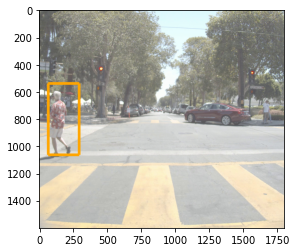

In [39]:
img = Image.open("dataset/pedestrian_detection/test/Images/FLIR_10097.jpg")
draw = ImageDraw.Draw(img)
im_width, im_height = img.size
xmin = (x-w)/2
ymin = (y-h)/2
xmax = (x+w)/2
ymax = (y+h)/2

(left, right, top, bottom) = ((-xmin * 1)*im_width, ((xmax * 1)+0.1)*im_width, ((-ymin * 1)+0.3)*im_height, ((ymax * 1)+0.6)*im_height)
draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=20, fill='Orange')

plt.imshow(img)
plt.show()

## 7、实验任务与参考解答

### 7.1实验任务

(1)回忆网络搭建过程，计算该实验所用的网络生成默认框的数量；

(2)请简述SSD网络正负样本匹配过程。

### 7.2参考解答

(1)：

${{19}^{2}}\times 3+{{10}^{2}}\times 6+{{5}^{2}}\times 6+{{3}^{2}}\times 6+{{2}^{2}}\times 6+{{1}^{2}}\times 6=1917$

(2)：

a、计算所有默认框与Ground Truth框的交并比。保存与Ground Truth交并比最大的默认框所对应的IOU值；

b、将与当前标注信息中的每个Ground Truth交并比最大的默认框所对应的IOU值置为2，即选为正样本；

c、将与Ground Truth交并比大于0.5的默认框也置为正样本；

d、判断是否比之前匹配过Ground Truth的交并比大；若是，则覆盖；

e、将所有正样本的交并比分数保存，并将其标签信息、坐标信息导出。
